In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
trait, indiv_group = "LDL", "white"
# trait, indiv_group = "height", "other"
# trait, indiv_group = "log_leukocyte", "other"

In [14]:
# read data
prefix = f"out/joint-fit/{trait}-{indiv_group}"
df_predint = pd.read_csv(f"{prefix}.predint.tsv", sep="\t", index_col=0)
df_params = pd.read_csv(f"{prefix}.params.tsv", sep="\t", index_col=0)
df_raw = pd.read_csv(
    f"../compile-data/out/per-trait-info/{trait}.tsv.gz", sep="\t", index_col=0
)

# Example

two males, same pred, different cal

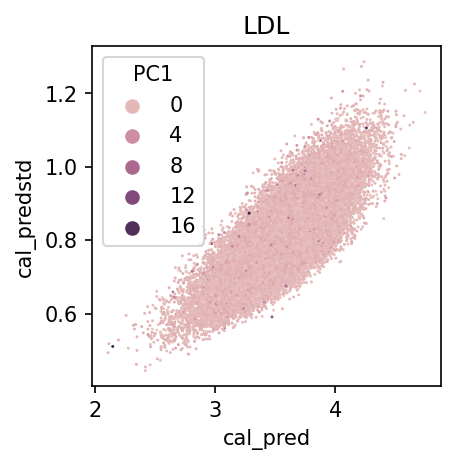

In [15]:
# visualize
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(
    data=df_predint, x="cal_pred", y="cal_predstd", linewidth=0, s=2, hue="PC1"
)
ax.set_title(trait)
fig.show()

In [16]:
print("Covariates that have largest gamma")
df_params.assign(gamma_abs=df_params["gamma"].abs()).sort_values(
    "gamma_abs", ascending=False
).head(n=10)

Covariates that have largest gamma


,beta,beta_se,beta_z,gamma,gamma_se,gamma_z,gamma_abs
const,3.575140,0.004173,856.825000,-0.440015,0.007240,-60.77710,0.440015
PGS,0.295630,0.003919,75.434700,0.195191,0.007246,26.93840,0.195191
AGE,0.059536,0.004492,13.255000,0.130881,0.008183,15.99450,0.130881
SEX,-0.049643,0.004128,-12.024800,0.036563,0.007393,4.94559,0.036563
years_of_edu,0.000674,0.004524,0.149039,-0.035618,0.007875,-4.52296,0.035618
log_BMI,0.036941,0.003579,10.322300,0.035411,0.007314,4.84153,0.035411
ever_smoked,-0.010832,0.004058,-2.669350,0.029794,0.007346,4.05583,0.029794
income,0.001290,0.004580,0.281575,-0.024723,0.008084,-3.05819,0.024723
PC4,0.002685,0.005762,0.465998,-0.024024,0.010303,-2.33172,0.024024
DEPRIVATION_INDEX,-0.024289,0.004218,-5.757830,0.023855,0.007494,3.18313,0.023855


In [17]:
plot_covar_list = ["PC1", "AGE", "SEX"]

In [28]:
# quantile range based on point prediction
q_min = 0.98
q_max = 1.0

# number of individuals to show
n_indiv = 6

In [29]:
def format_df_plot(df):
    df = df.copy()
    for col in ["AGE", "SEX"]:
        if col in df.columns:
            df[col] = df_raw[col][df.index]

    if "SEX" in df:
        df["SEX"] = df["SEX"].apply(lambda s: "Male" if s == 1 else "Female")

    df = df.rename(
        columns={
            "SEX": "Sex",
            "DEPRIVATION_INDEX": "Deprivation",
            "AGE": "Age",
        }
    )
    df = df.round(2)
    return df

In [30]:
df_plot = df_predint[
    df_predint["cal_pred"].between(
        df_predint["cal_pred"].quantile(q=q_min),
        df_predint["cal_pred"].quantile(q=q_max),
    )
]

df_plot = (
    df_plot.sort_values("cal_predstd")
    .iloc[list(np.arange(0, n_indiv // 2)) + list(np.arange(-n_indiv // 2, 0)), :][
        [*plot_covar_list, "cal_pred", "cal_predstd"]
    ]
    .copy()
)

df_plot = format_df_plot(df_plot)
df_plot.index = np.arange(1, len(df_plot) + 1)

In [31]:
display(df_plot)

,PC1,Age,Sex,cal_pred,cal_predstd
1,0.49,50,Female,4.18,0.82
2,-0.97,47,Female,4.22,0.83
3,-0.29,45,Female,4.19,0.84
4,-0.09,67,Male,4.28,1.24
5,0.29,69,Male,4.22,1.27
6,-0.33,65,Male,4.24,1.29


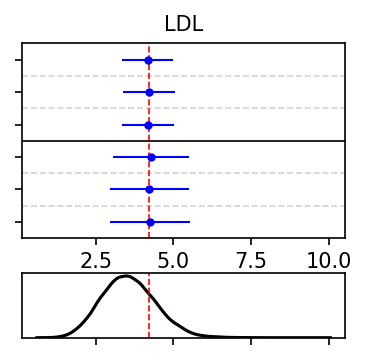

In [32]:
fig, axes = plt.subplots(
    figsize=(2.5, 2.5), dpi=150, nrows=2, gridspec_kw={"height_ratios": [3, 1]}
)
n_indiv = len(df_plot)
axes[0].errorbar(
    y=np.arange(n_indiv - 1, -1, -1),
    x=df_plot["cal_pred"],
    xerr=df_plot["cal_predstd"],
    fmt=".",
    color="blue",
    lw=1.0,
)
for i in range(n_indiv - 1):
    axes[0].axhline(y=i + 0.5, ls="--", color="lightgray", lw=0.8)

axes[0].axhline(y=2.5, ls="-", color="black", lw=0.8)
axes[0].set_ylim(-0.5, n_indiv - 0.5)
axes[0].set_yticks(np.arange(n_indiv))
axes[0].set_yticklabels([])

sns.kdeplot(df_predint["pheno"].values, ax=axes[1], color="black")
axes[1].set_yticks([])
axes[1].set_ylabel(None)
axes[0].set_xlim(axes[1].get_xlim())
axes[1].set_xticklabels([])

axes[0].axvline(x=df_plot["cal_pred"].mean(), ls="--", lw=0.8, color="red")
axes[1].axvline(x=df_plot["cal_pred"].mean(), ls="--", lw=0.8, color="red")
axes[0].set_title(f"{trait}", fontsize=10)

fig.tight_layout()
plt.subplots_adjust(hspace=0.27)

In [12]:
# df_tmp["cal_predstd_q"] = pd.qcut(df_tmp["cal_predstd"], q=30).cat.codes
# a = df_tmp.groupby("cal_predstd_q").apply(
#     lambda df: np.sqrt(np.mean((df["cal_pred"] - df["pheno"]) ** 2))
# )
# b = df_tmp.groupby("cal_predstd_q").apply(lambda df: np.mean(df["cal_predstd"]))

# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(a, b)
# ax.axline((5, 5), slope=1, color="black", ls="--")